In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('HomeWork.csv', index_col=0,parse_dates=['date'])

In [3]:
df.head()

status  income   age       date
0    Student  4000.0  18.0 2022-01-23
1  Pensioner     NaN  91.0 2022-01-19
2    Student  4000.0  18.0 2022-01-03
3    Student     0.0   NaN 2022-01-13
4  Pensioner  5000.0  87.0 2022-01-31

## 1. Разведочный анализ данных

In [4]:
print('Dataframe shape: ', df.shape)

Dataframe shape:  (500, 4)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   status  490 non-null    object        
 1   income  430 non-null    float64       
 2   age     441 non-null    float64       
 3   date    500 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 19.5+ KB


In [6]:
df.describe()

income         age
count     430.000000  441.000000
mean   152020.623256   46.362812
std    242647.036978   25.036517
min    -13745.000000    0.000000
25%      2000.000000   23.000000
50%     21000.000000   44.000000
75%    217000.000000   68.000000
max    992000.000000   99.000000

Из описательных характеристик видим, что есть люди возрастом 0 лет, а также люди с отрицательным доходом, что скорее всего является выбросами.

In [7]:
df.status.unique()

array(['Student', 'Pensioner', 'Businessman', 'Working', nan],
      dtype=object)

Посмотрим число пропусков

In [8]:
df.isna().sum()

status    10
income    70
age       59
date       0
dtype: int64

Теперь посмотрим распределение по возрасту

In [9]:
ax = sns.displot(data =df, x='age')
ax.fig.suptitle('Age distribution',
              y=1.03)
plt.show()

И насколько равномерно распределены люди по категориям

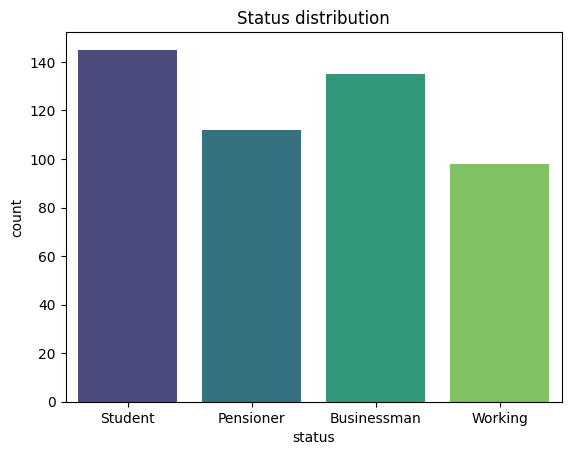

In [10]:
g = sns.countplot(data=df, x='status', palette='viridis').set_title('Status distribution')
plt.show()

Построим boxplot с распределением по статусу возраста и заработка

In [11]:
sns.boxplot(data=df, x='income', y='status')
plt.show()

Ситуация предсказуемая, медианный доход бизнесменов больше медианного дохода работающих, а также пенсионеров и студентов. Судя по распределению меньше всего зарабатывают студенты.

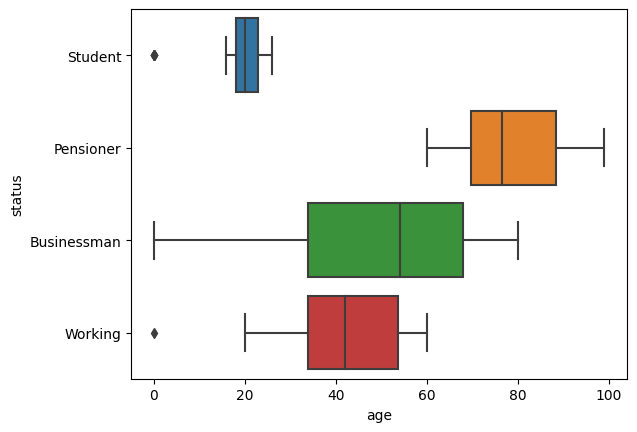

In [12]:
sns.boxplot(data=df, x='age', y='status')
plt.show()

По графику можно сделать логичный вывод о том, что старее всех - пенсионеры, а моложе - студенты. При этом есть люди 0 возраста в работающих, а также студентах и видимо бизнесменов. Придется избавиться от выбросов, держа в голове логическое правило о том, что ранее 18 лет бизнесменом быть и работающим быть вряд ли возможно.

### 1.2 Resample

In [13]:
income_age_resample = df.resample('1d', on='date')[['income', 'age']].median().reset_index()

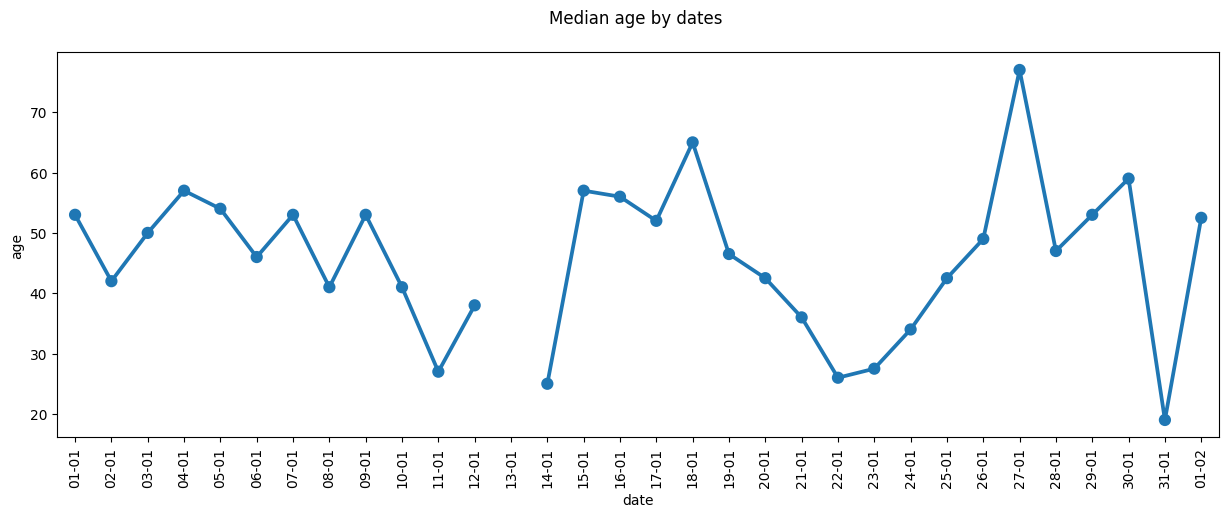

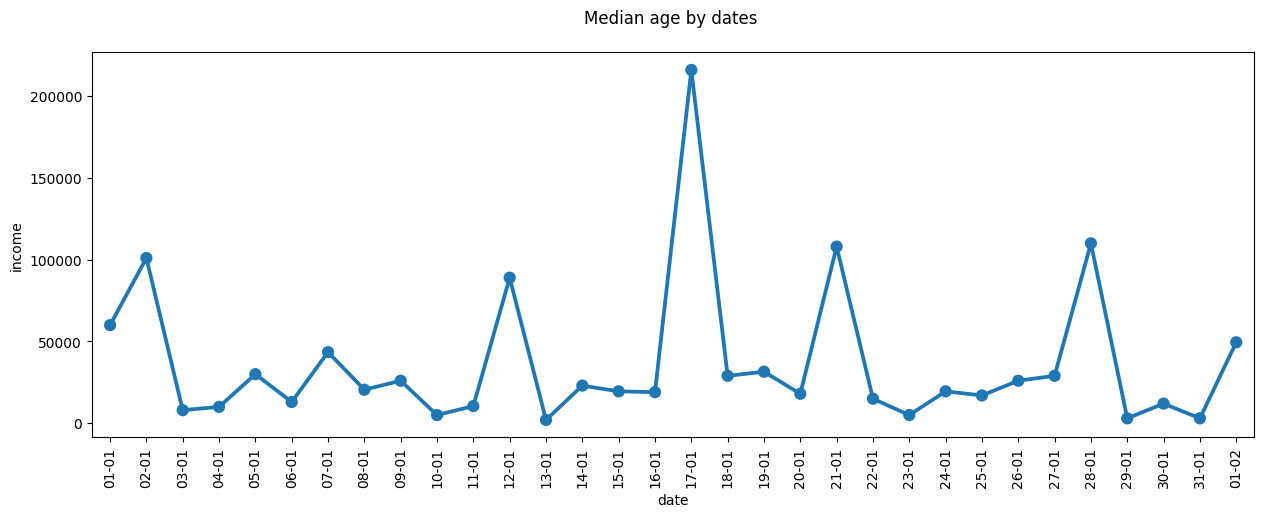

In [14]:
plt.figure(figsize=(15,5))
age_gr = sns.pointplot(data=income_age_resample,
            x='date',
            y='age')
age_gr.set_xticklabels(income_age_resample['date'].dt.strftime('%d-%m'))
age_gr.set_title('Median age by dates \n')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(15,5))
income_gr = sns.pointplot(data=income_age_resample,
            x='date',
            y='income')
income_gr.set_xticklabels(income_age_resample['date'].dt.strftime('%d-%m'))
income_gr.set_title('Median age by dates \n')
plt.xticks(rotation=90)
plt.show()

По resample очевидно, что есть пропуски в возрасте с 12 января по 14 января.

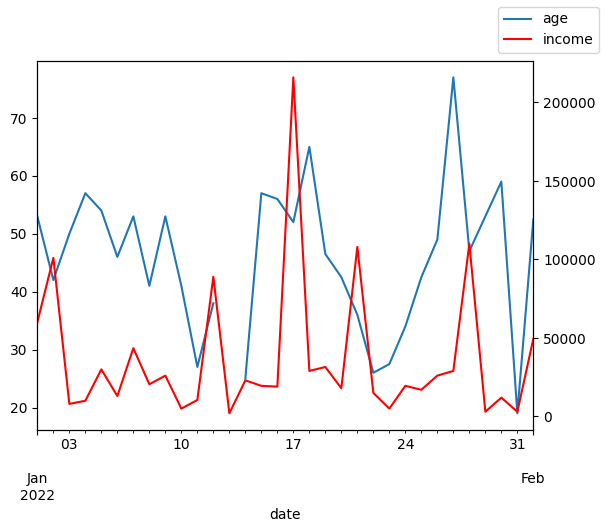

In [15]:
ax = income_age_resample.plot(x="date", y="age", legend=False)
ax2 = ax.twinx()
income_age_resample.plot(x="date", y="income", ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.show()

In [16]:
df['age'].corr(df['income'])

0.13102164905447422

Наблюдается некоторая слабая корреляция между возрастом и уровнем дохода, но скорее всего она нелинейна

In [17]:
sns.relplot(kind='scatter', data=df, x='age', y='income', hue='status')

Кластеры достаточно четко прослеживаются. Посмотрим общую аналитику

In [18]:
df.groupby('status').agg({'income': ['min', 'max', 'median','mean'],
                         'age': ['min', 'max', 'median','mean']}).round(2)

income                                  age                    
                 min       max    median       mean   min   max median   mean
status                                                                       
Businessman -13430.0  992000.0  464000.0  432494.69   0.0  80.0   54.0  50.83
Pensioner   -13035.0   30000.0   17000.0   15833.69  60.0  99.0   76.5  78.66
Student     -13745.0    5000.0    2000.0    1104.41   0.0  26.0   20.0  20.06
Working     -13027.0  299000.0  110000.0  123171.90   0.0  60.0   42.0  41.93

## 2. Обработка пропусков и выбросов

1. Для начала разберемся с возрастом, просмотрим число выбросов. Логичным кажется убрать выбросы в меньшую сторону, т.к. сверху особых выбросов на boxplot не наблюдается.

Заменим возраст менее 16 лет на Nan

In [19]:
df.age=df.age.where(df.age>16)

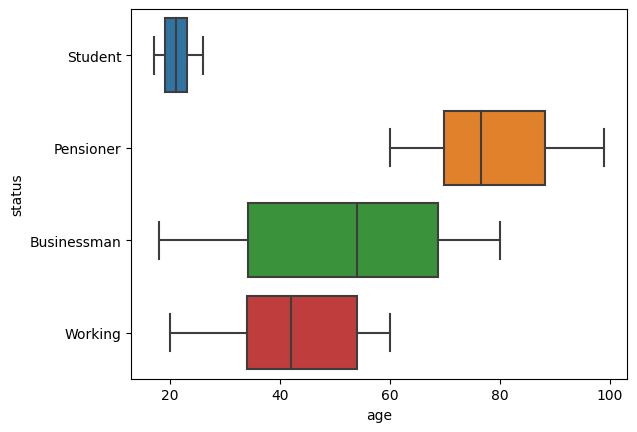

In [20]:
sns.boxplot(data=df, x='age', y='status')
plt.show()

Проверим, есть ли отрицательный доход

In [21]:
df[df.income<0].head(20)

status   income   age       date
15       Working  -2658.0  42.0 2022-01-31
19       Student -12222.0  20.0 2022-01-11
21       Working  -9399.0  38.0 2022-01-07
25       Student  -9219.0  19.0 2022-01-11
26       Student -12362.0  21.0 2022-01-16
27       Working -13027.0  37.0 2022-01-14
36       Working  -8273.0  42.0 2022-01-23
50     Pensioner  -2665.0  69.0 2022-01-19
55       Student  -9135.0  17.0 2022-01-31
58       Student -12556.0  21.0 2022-01-16
64       Working  -6472.0  53.0 2022-01-06
70       Working  -4463.0  48.0 2022-01-20
81   Businessman  -8212.0   NaN 2022-01-10
103      Student  -8169.0  24.0 2022-01-05
119      Student -13745.0  22.0 2022-01-09
120      Student  -1600.0  17.0 2022-01-16
122  Businessman  -2133.0  28.0 2022-02-01
131      Working -12331.0  41.0 2022-01-10
136      Working -13020.0  37.0 2022-01-15
162  Businessman  -9288.0  21.0 2022-01-02

Заменим его на модуль, т.к. скорее всего здесь допущена ошибка

In [22]:
df.income = df.income.abs()

In [23]:
print('Число строк с пропусками составляет', round(df[df.isna().any(axis=1)].shape[0]*100 / df.shape[0], 2), '%')

Число строк с пропусками составляет 28.2 %


## Обработка пропусков

Поскольку пропусков около 15%, давайте посмотрим стоблцы.

In [24]:
df.isna().sum()

status    10
income    70
age       78
date       0
dtype: int64

Для начала проверим строки, в которых все пропуски, от таких лучше избавиться.

In [25]:
df[df[['income', 'age', 'status']].isna().all(axis=1)]

status  income  age       date
378    NaN     NaN  NaN 2022-01-22

In [26]:
a = df[df[['income', 'age', 'status']].isna().all(axis=1)].index

In [27]:
df.drop(labels = a, 
        axis='index', 
        inplace=True)

Посмотрим распределение возраста пенсионеров

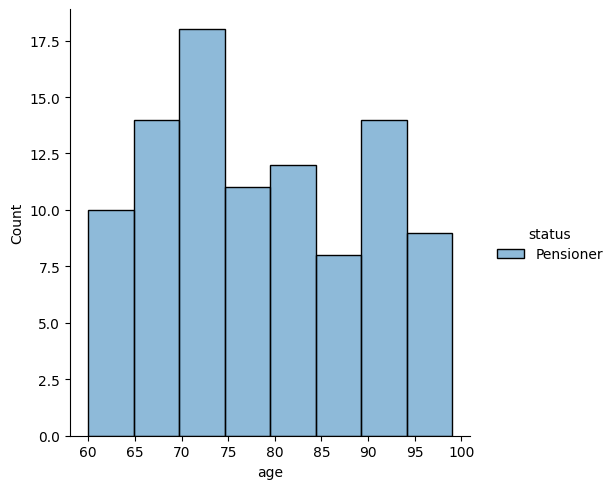

In [28]:
sns.displot(data=df[df.status == 'Pensioner'], x='age', hue='status')

In [29]:
df[df.status == 'Pensioner'].age.isna().sum()

16

Очевидно, что пенсионеров моложе 60 не бывает. Поскольку у многих есть пропуски, связанные с возрастом, то напишем функцию, которая будет заполять пропуски на основе существующего распределения в столбце

In [30]:
def fill_with_currest_distr(
    input_df: pd.DataFrame,
    column_tofill: str
) -> pd.DataFrame:
    """
    Заполняет в DataFrame пропуски с учетом существующего распределения признака
    """
    if input_df[column_tofill].isna().sum() > 0:
        s = input_df[column_tofill].value_counts(normalize=True)
        missing = input_df[column_tofill].isnull()
        input_df.loc[missing, column_tofill] = np.random.choice(s.index, size=len(input_df[missing]), p=s.values)
    return input_df

Заполним пропуски в возрасте на основе имеющегося распределения. То есть если у пользователя статус "пенсионер", то он получит возраст от 60+, студент другой и т.д.

In [31]:
for i in ['Student', 'Pensioner', 'Businessman', 'Working']:
    df.loc[(df.status == i)] = fill_with_currest_distr(df.loc[(df.status == i)], 'age')

In [32]:
df.isna().sum()

status     9
income    69
age        1
date       0
dtype: int64

Аналогично можно сделать с доходом, в соответствии с возрастом

In [33]:
for i in ['Student', 'Pensioner', 'Businessman', 'Working']:
    df.loc[(df.status == i)] = fill_with_currest_distr(df.loc[(df.status == i)], 'income')

In [34]:
df.isna().sum()

status    9
income    1
age       1
date      0
dtype: int64

In [35]:
df[df.status.isna()]

status    income   age       date
35     NaN  286000.0  53.0 2022-01-30
65     NaN       NaN  76.0 2022-01-10
83     NaN  262000.0  35.0 2022-01-19
169    NaN    9000.0  85.0 2022-01-19
197    NaN  169000.0  59.0 2022-01-17
359    NaN   30000.0   NaN 2022-01-05
376    NaN    7248.0  81.0 2022-01-12
382    NaN   79000.0  24.0 2022-01-22
468    NaN  691000.0  54.0 2022-01-10

Логичным является заполнение статуса на основе дохода

In [37]:
df = fill_with_currest_distr(df, 'status')

In [38]:
df.isna().sum()

status    0
income    1
age       1
date      0
dtype: int64

In [39]:
df[df.isna().any(axis=1)]

status   income   age       date
65   Working      NaN  76.0 2022-01-10
359  Student  30000.0   NaN 2022-01-05

In [40]:
df = fill_with_currest_distr(df, 'age')
df = fill_with_currest_distr(df, 'income')

# 3. Посмотрим окончательный датафрейм

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499 entries, 0 to 499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   status  499 non-null    object        
 1   income  499 non-null    float64       
 2   age     499 non-null    float64       
 3   date    499 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 19.5+ KB


In [42]:
df.describe()

income         age
count     499.000000  499.000000
mean   157335.963928   47.084168
std    249534.207189   24.354414
min         0.000000   17.000000
25%      4000.000000   23.000000
50%     21000.000000   44.000000
75%    218000.000000   68.000000
max    992000.000000   99.000000

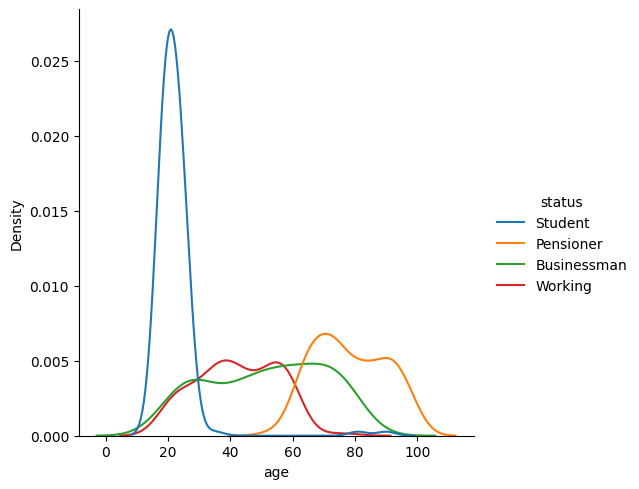

In [43]:
sns.displot(data=df, x='age', hue='status',kind='kde')

In [44]:
df.head()

status   income   age       date
0    Student   4000.0  18.0 2022-01-23
1  Pensioner  21000.0  91.0 2022-01-19
2    Student   4000.0  18.0 2022-01-03
3    Student      0.0  26.0 2022-01-13
4  Pensioner   5000.0  87.0 2022-01-31